Dear Denis, this file contains the original codes of AESM1455 and below my try on solving the system using full fractional flow.

In [307]:
import numpy as np
#import torch as tr
import timeit
import matplotlib.pyplot as plt

def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")
        
def vecprint(x, fmt="g"):
    for i, y in enumerate(x):
        print(("{:"+str(i)+fmt+"}").format(y), end="  ")
    print("")    

one_d = False

#setting geometry
nx = 20
ny = 20

nb = nx * ny # number of blocks
nc = 2    # number of equations/unknowns
Theta = 50  # V phi dx / k A dt

#well settings
p_inj = 200
p_prod = 100
#s_inj = 0.9

    #added
z_inj = 0.99



#well locations
i_inj = 0
i_prod = nb-1

#setting initial conditions
#s = np.ones(nb)*0.1
p = np.ones(nb)*150

    #added
z = np.ones(nb) * 0.01


#reservoir parameters
p_0 = 1
c_o = 1e-5
c_w = 1e-5
c_g = 1e-5
rho_o0 = 20
rho_g0 = 20
rho_w0 = 20
mu_o = 2                  #viscosity
mu_w = 2                  #viscosity
mu_g = 2
n_o = 2                   #
n_w = 2                   #
n_g = 2




In [308]:
def RachfordRice(z1):

    z = np.array([z1, 1-z1])
    K = np.array([3, 0.1])
    r = lambda v: np.sum(z*(K-1)/(v*(K-1)+1))
    a = 1 / (1 - np.max(K))
    b = 1 / (1 - np.min(K))

    for i in range(1000):
        v = 0.5 * (a + b)
        if r(v) > 0:
            a = v
        else:
            b = v

        if np.abs(r(v)) < 1e-12:
            break

    x = z/(v*(K-1)+1)
    y = K * x

    return x, y

x, y = RachfordRice(z_inj)
x0 = x[0] 
x2_0 = 1-x[0]
y0  = y[0] 
y2_0 = 1-y[0]
print(x0, y0)
print(x[0], y[0])

0.310344827586204 0.9310344827586121
0.310344827586204 0.9310344827586121


In [309]:
# #modified functions

# rho_w = lambda p: rho_w0 * (1+c_w*(p-p_0))
# rho_o = lambda p: rho_o0 * (1+c_o*(p-p_0))
# rho_g = lambda p: rho_g0 * (1+c_g*(p-p_0))

# #saturation equation, x and y are always x[0] and y[0] in binary system
# s = lambda z : (z - y[0]) / (x[0] - y[0])
# f = lambda s: s**2 / (s**2 + 10.*(1-s)**2)
# df_ds = lambda s: (f(s + 1e-8) - f(s)) / 1e-8 if s > 0 and s < 1 else 0

# a = dict([(0, lambda p, z: rho_w(p) * s(z)),
#          (1, lambda p, z: rho_o(p)* (1-s(z)))])



# b = dict([(0, lambda p, z: rho_o(p) * (x[0] * f(s(z)) + y[0]*(1-f(s(z))))),
#          (1, lambda p, z: rho_o(p) * (x[0] * f(1-s(z)) + y[0]*(1-f(1-s(z)))))])

# bh = lambda j, pl, zl, pr, zr: b[j](pl, zl) if pl > pr else b[j](pr, zr)

# da_dp = dict([(0, lambda p, z: s(z)* rho_w0 *c_w),
#               (1, lambda p, z: (1-s(z))* rho_o0 *c_o)])
# da_dz = dict([(0, lambda p, z: rho_w(p)),
#               (1, lambda p, z: -rho_o(p))])
# db_dp = dict([(0, lambda p, z: (rho_o0 *c_o)* (x[0] * f(s(z)) + y[0]*(1-f(s(z))))),
#               (1, lambda p, z: (rho_o0 *c_o)* (x[0] * f(1-s(z)) + y[0]*(1-f(1-s(z)))))])
# db_dz = dict([(0, lambda p, z: ( (x[0]-y[0])*df_ds(s(z)) ) * ( 1/(x[0]-y[0])) if s(z) > 0 and s(z) < 1 else 1),
#               (1, lambda p, z: ( (x[0]-y[0])*df_ds(1-s(z)) ) * ( 1/(x[0]-y[0])) if (1-s(z)) > 0 and (1-s(z)) < 1 else 1)])

# dbh_dpl = lambda j, pl, zl, pr, zr: db_dp[j](pl,zl) if pl > pr else 0
# dbh_dpr = lambda j, pl, zl, pr, zr: db_dp[j](pr,zr) if pl < pr else 0
# dbh_dzl = lambda j, pl, zl, pr, zr: db_dz[j](pl,zl) if pl > pr else 0
# dbh_dzr = lambda j, pl, zl, pr, zr: db_dz[j](pr,zr) if pl < pr else 0

In [310]:
rho_w = lambda p: rho_w0 * (1+c_w*(p-p_0))
rho_o = lambda p: rho_o0 * (1+c_o*(p-p_0))
rho_g = lambda p: rho_g0 * (1+c_g*(p-p_0))

a = dict([(0, lambda p, z: rho_o(p) * z),
          (1, lambda p, z: rho_g(p)* (1-z))])

b = dict([(0, lambda p, z: rho_o(p)* x0 * (    z**n_o /mu_o)),
          (1, lambda p, z: rho_g(p)* y0 * ((1-z)**n_g /mu_g))])

da_dp = dict([(0, lambda p, z: z    * rho_o0 *c_o),
              (1, lambda p, z: (1-z)* rho_g0 *c_g)])
da_dz = dict([(0, lambda p, z:  rho_o(p)),
              (1, lambda p, z: -rho_g(p))])
db_dp = dict([(0, lambda p, z: rho_o0 * c_o * x0 * (    z**n_o /mu_o)),
              (1, lambda p, z: rho_g0 * c_g * y0 * ((1-z)**n_g /mu_g))])
db_dz = dict([(0, lambda p, z:   rho_o(p) * x0 *n_o * z**(n_w-1) / mu_o ),
              (1, lambda p, z: - rho_g(p) * y0 *n_g * z**(n_o-1) / mu_g )])

bh = lambda j, pl, zl, pr, zr: b[j](pl, zl) if pl > pr else b[j](pr, zr)

dbh_dpl = lambda j, pl, zl, pr, zr: db_dp[j](pl,zl) if pl > pr else 0
dbh_dpr = lambda j, pl, zl, pr, zr: db_dp[j](pr,zr) if pl < pr else 0
dbh_dzl = lambda j, pl, zl, pr, zr: db_dz[j](pl,zl) if pl > pr else 0
dbh_dzr = lambda j, pl, zl, pr, zr: db_dz[j](pr,zr) if pl < pr else 0

-0.09500000000001467 1.4838888888888886


In [311]:
# #Original functions of AESM1455

# rho_w = lambda p: rho_w0 * (1+c_w*(p-p_0))
# rho_o = lambda p: rho_o0 * (1+c_o*(p-p_0))
# rho_g = lambda p: rho_g0 * (1+c_g*(p-p_0))

# #saturation equation, x and y are always x[0] and y[0] in binary system
# s = lambda z : (z - y[0]) / (x[0] - y[0])
# f = lambda s: s**2 / (s**2 + 10.*(1-s)**2)
# df_ds = lambda s: (f(s + 1e-8) - f(s)) / 1e-8 if s > 0 and s < 1 else 0

# a = dict([(0, lambda p, z: rho_o(p) * z),
#           (1, lambda p, z: rho_o(p)* (1-z))])

# b = dict([(0, lambda p, z: rho_o(p) * (x[0] * f(s(z)) + y[0]*(1-f(s(z))))),
#           (1, lambda p, z: rho_o(p) * (x[0] * f(s(1-z)) + y[0]*(1-f(s(1-z)))))])

# da_dp = dict([(0, lambda p, z: z* rho_o0 *c_o),
#               (1, lambda p, z: (1-z)* rho_o0 *c_o)])
# da_dz = dict([(0, lambda p, z: rho_o(p)),
#               (1, lambda p, z: -rho_o(p))])
# db_dp = dict([(0, lambda p, z: (rho_o0 *c_o)* (x[0] * f(s(z)) + y[0]*(1-f(s(z))))),
#               (1, lambda p, z: (rho_o0 *c_o)* (x[0] * f(s(1-z)) + y[0]*(1-f(s(1-z)))))])
# db_dz = dict([(0, lambda p, z: ( (x[0]-y[0])*df_ds(s(z)) ) * ( 1/(x[0]-y[0])) if s(z) > 0 and s(z) < 1 else 1),
#               (1, lambda p, z: ( (x[0]-y[0])*df_ds(s(1-z)) ) * ( 1/(x[0]-y[0])) if s(1-z) > 0 and s(z) < 1 else 1)])

# bh = lambda j, pl, zl, pr, zr: b[j](pl, zl) if pl > pr else b[j](pr, zr)

# dbh_dpl = lambda j, pl, zl, pr, zr: db_dp[j](pl,zl) if pl > pr else 0
# dbh_dpr = lambda j, pl, zl, pr, zr: db_dp[j](pr,zr) if pl < pr else 0
# dbh_dzl = lambda j, pl, zl, pr, zr: db_dz[j](pl,zl) if pl > pr else 0
# dbh_dzr = lambda j, pl, zl, pr, zr: db_dz[j](pr,zr) if pl < pr else 0

In [312]:
def add_injector(rhs, p, z, i):
    for j in [0,1]:
        rhs[nc * i+ j] += b[j](p_inj, z_inj) * (p[i] - p_inj)
        
def add_producer(rhs, p, z, i):
    for j in [0,1]:
        rhs[nc * i+ j] += b[j](p[i], z[i]) * (p[i] - p_prod)
        
def add_injector_to_jac(rhs, jac, p, z, i):
    for j in [0,1]:
        rhs[nc * i+ j] += b[j](p_inj, z_inj) * (p[i] - p_inj)
        jac[nc * i+ j, nc * i + 0] += b[j](p_inj, z_inj)
        
def add_producer_to_jac(rhs, jac, p, z, i):
    for j in [0,1]:
        rhs[nc * i+ j] += b[j](p[i], z[i]) * (p[i] - p_prod)
        jac[nc * i+ j, nc * i + 0] += b[j](p[i], z[i]) + db_dp[j](p[i],z[i]) * (p[i] - p_prod)
        jac[nc * i+ j, nc * i + 1] += db_dz[j](p[i],z[i]) * (p[i] - p_prod)
        

In [313]:
#Building of the jac and RHS, connection based

def jac_rhs_analytic_conn(vars, vars_n, Theta):
    jac = np.zeros((nc*nb,nc*nb))
    rhs = np.zeros(nc*nb)
    p = vars[0::nc]
    z = vars[1::nc]
    pn = vars[0::nc]
    zn = vars[1::nc]
    
    for j in [0,1]:
        for i in range(nb):
            rhs[nc* i + j] = Theta * (a[j](p[i], z[i]) - a[j](pn[i], zn[i]))
            
            jac[nc* i + j, nc * i + 0] = Theta * da_dp[j](p[i], z[i])
            jac[nc* i + j, nc * i + 1] = Theta * da_dz[j](p[i], z[i])
        
        for k in range (nconns):
            l = lb[k]
            r = rb[k]
            G = Trans[k]
            
            Qk = G * bh(j, p[l], z[l], p[r], z[r]) * (p[l] - p[r])
            
            rhs[nc * l + j] += Qk
            rhs[nc * r + j] -= Qk
            
            dQk_dpl = G *dbh_dpl(j, p[l], z[l], p[r], z[r]) * (p[l] - p[r]) + G * bh(j, p[l], z[l], p[r], z[r])
            dQk_dpr = G *dbh_dpr(j, p[l], z[l], p[r], z[r]) * (p[l] - p[r]) - G * bh(j, p[l], z[l], p[r], z[r])
            
            jac[nc* l + j, nc * l + 0] += dQk_dpl
            jac[nc* l + j, nc * r + 0] += dQk_dpr 
            
            jac[nc* r + j, nc * l + 0] -= dQk_dpl
            jac[nc* r + j, nc * r + 0] -= dQk_dpr 
            
            dQk_dzl = G *dbh_dzl(j, p[l], z[l], p[r], z[r]) * (p[l] - p[r])
            dQk_dzr = G *dbh_dzr(j, p[l], z[l], p[r], z[r]) * (p[l] - p[r])
            
            jac[nc* l + j, nc * l + 1] += dQk_dzl
            jac[nc* l + j, nc * r + 1] += dQk_dzr 
            
            jac[nc* r + j, nc * l + 1] -= dQk_dzl             
            jac[nc* r + j, nc * r + 1] -= dQk_dzr 
            
    add_injector(rhs, p, z, i_inj)
    add_producer(rhs, p, z, i_prod)
    add_injector_to_jac(rhs, jac, p, z, i_inj)
    add_producer_to_jac(rhs, jac, p, z, i_prod)
    
    return rhs, jac

In [314]:
#defining connections and solving iteration system, theta_ref included to try and find stability..

start = timeit.default_timer()

vars = np.zeros(nc * nb)
vars[0::nc] = p
vars[1::nc] = z

if one_d:
    nconns = nb - 1
    lb = np.arange(nconns)
    rb = lb + 1
    Trans = np.ones(nconns)

else:
    nconns = (nx -1) *ny + nx * (ny - 1)
    lb = np.zeros(nconns, dtype=np.int32)
    rb = np.zeros(nconns, dtype=np.int32)
    Trans = np.ones(nconns)
    
    for i in range(nx-1):
        for j in range(ny):
            k = i + j * (nx - 1)
            lb[k] = i + j * nx
            rb[k] = i + j * nx + 1
            
    shift = (nx -1) * ny
    for i in range(nx):
        for j in range(ny-1):
            k = shift + i + j * nx
            lb[k] = i + j * nx
            rb[k] = i + j * nx + nx

for t in range(100):
    vars_n = np.array(vars, copy='True')
    
    theta_ref = Theta 
    for k in range(10):
        #rhs, jac = jac_numeric(vars, vars_n)
        #rhs, jac = jac_analytic(vars, vars_n)
        rhs, jac = jac_rhs_analytic_conn(vars, vars_n, theta_ref)
         
        #matprint(jac)
        #print('')
#         matprint(jac2)
#         print('')
#         vecprint(rhs)
#         print('')
#         vecprint(rhs1)
#         print('')
        
        res = np.linalg.norm(rhs)
        if res < 1e-3:
            print("T = %d, iter = %d, res = %e" % (t+1,k,res))
            break
        
        dx = np.linalg.solve(jac, -rhs)
        
        vars += dx
        theta_ref = Theta   
    
    #fig.canvas.draw()
print('pressure', vars[0::nc])
print('z', vars[1::nc])

stop = timeit.default_timer()

print('CPU = %5.3f sec' % (stop - start))

pressure [184.76904384 169.52310478 160.25300081 153.75703257 148.75814438
 144.67028136 141.1887835  138.13840353 135.40964069 132.92842554
 130.63924177 128.49840821 126.67317978 126.10208105 125.7553095
 125.46882169 125.24056004 125.06979222 124.95610382 124.89929654
 169.52310478 163.4744512  157.37952676 152.15594264 147.74660772
 143.96815211 140.66565239 137.72641376 135.06980063 132.63591324
 130.37613654 128.25307245 126.55687073 126.04128104 125.69602278
 125.41059407 125.18306457 125.01271135 124.89922139 124.84248807
 160.25300081 157.37952676 153.53487282 149.64134897 146.00846938
 142.69823052 139.69033868 136.94374408 134.41638031 132.06902363
 129.86258227 127.76706894 126.36451525 125.91813302 125.57733808
 125.29446545 125.06839111 124.89876574 124.785581   124.72894503
 153.75703257 152.15594264 149.64134897 146.77166124 143.8568859
 141.03841724 138.36829063 135.85631826 133.49327577 131.25996473
 129.12782023 127.09355549 126.1357502  125.73520556 125.40081576
 12

<IPython.core.display.Javascript object>


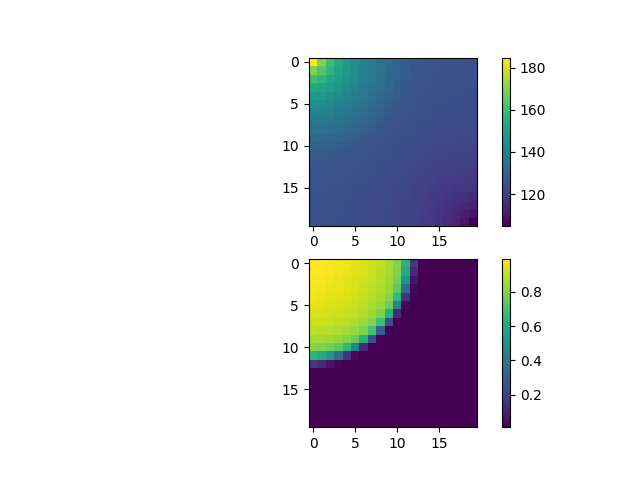

<IPython.core.display.Javascript object>


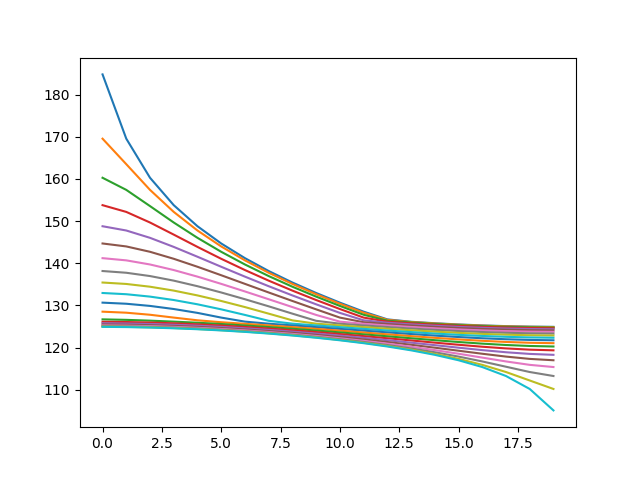

[[184.76904384 169.52310478 160.25300081 153.75703257 148.75814438
  144.67028136 141.1887835  138.13840353 135.40964069 132.92842554
  130.63924177 128.49840821 126.67317978 126.10208105 125.7553095
  125.46882169 125.24056004 125.06979222 124.95610382 124.89929654]
 [169.52310478 163.4744512  157.37952676 152.15594264 147.74660772
  143.96815211 140.66565239 137.72641376 135.06980063 132.63591324
  130.37613654 128.25307245 126.55687073 126.04128104 125.69602278
  125.41059407 125.18306457 125.01271135 124.89922139 124.84248807]
 [160.25300081 157.37952676 153.53487282 149.64134897 146.00846938
  142.69823052 139.69033868 136.94374408 134.41638031 132.06902363
  129.86258227 127.76706894 126.36451525 125.91813302 125.57733808
  125.29446545 125.06839111 124.89876574 124.785581   124.72894503]
 [153.75703257 152.15594264 149.64134897 146.77166124 143.8568859
  141.03841724 138.36829063 135.85631826 133.49327577 131.25996473
  129.12782023 127.09355549 126.1357502  125.73520556 125.400

<function print>

In [333]:
#plotting

import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

if one_d:
    x1 = np.linspace(0,1,nb)
    ax1.plot(vars[0::nc])
    ax2.plot(vars[1::nc])
else: 
    z1 = np.reshape(vars[0::nc], [ny, nx])
    pl1 = ax1.imshow(z1)
    z2 = np.reshape(vars[1::nc], [ny, nx])
    pl2 = ax2.imshow(z2)
    
    fig.colorbar(pl1, ax=ax1)
    fig.colorbar(pl2, ax=ax2)
    plt.figure()
    plt.plot(z1)
    print(z1)
    
plt.show()
print

<IPython.core.display.Javascript object>


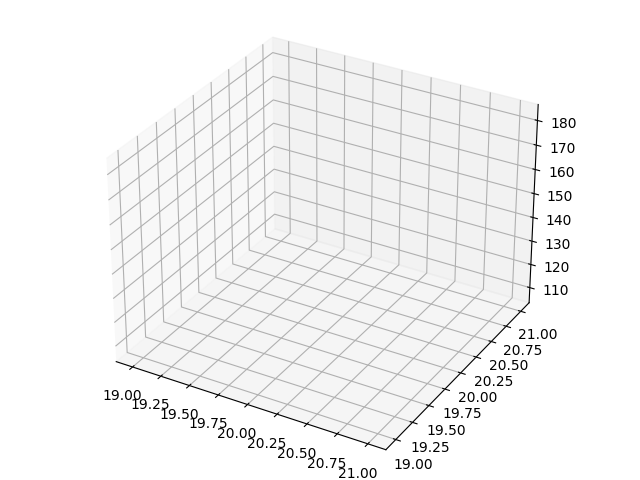

C:\Users\Bouke\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  if __name__ == '__main__':


In [331]:
%matplotlib notebook
import matplotlib.pyplot as plt

if one_d:
    nb=1
else:
    fig = plt.figure()
    X,Y = np.meshgrid(nx,ny)
    ax = Axes3D(fig)
    ax.plot_surface(X,Y,z1,rstride=1,cstride=1,cmap= cm.jet,linewidth=1)